<a href="https://colab.research.google.com/github/edoardorossi1995/Tesi/blob/main/DQN_NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drive & Environment Setting

In [1]:
IN_COLAB = False

try:
  import google.colab
  IN_COLAB = True
except:
  pass

if IN_COLAB == True:
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd /content/gdrive/MyDrive/Tesi_GDrive
  PROJECT_PATH = '/content/gdrive/MyDrive/Tesi_GDrive'
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  print("1")
  if gpu_info.find('failed')>=0:
    print('Not connetcted to a gpu')
  else:
    print(gpu_info)
    print("2")
  from psutil import virtual_memory
  ram_gb = virtual_memory().total / 1e9
  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

  if ram_gb < 20:
    print('Not using a high-RAM runtime')
  else:
    print('You are using a high-RAM runtime!')  
  
  #!ls
else:
  %cd /Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive
  PROJECT_PATH = '/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive'

import warnings
import pickle
import sys
import os

if IN_COLAB == True:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))
else:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from keras.models import Sequential, Model
from keras.layers import Dense, Lambda
from keras.layers import Activation
from keras.activations import exponential, relu
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Layer, InputSpec, Reshape
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
tf.config.run_functions_eagerly(True)
from scipy.optimize import minimize, differential_evolution

from pkl import store_data, load_data
from functions.compressor import compress
from functions.compressor_param import compress_2

import random
from collections import defaultdict

import time



print("Libraries imported")

Mounted at /content/gdrive
/content/gdrive/MyDrive/Tesi_GDrive
1
Sat May 20 17:44:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                       

# Import CTA

In [2]:
cta30_def_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_def.csv')
CTA30_def = [cta30_def_path]
  
df_def = pd.read_csv(CTA30_def[0])

cta30_18_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2018.csv')
cta30_19_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2019.csv')
cta30_20_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2020.csv')
cta30_21_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2021.csv')
cta30_22_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2022.csv')
CTA30_18 = [cta30_18_path]
CTA30_19 = [cta30_19_path]
CTA30_20 = [cta30_20_path]
CTA30_21 = [cta30_21_path]
CTA30_22 = [cta30_22_path]

df18= pd.read_csv(CTA30_18[0])
df19= pd.read_csv(CTA30_19[0])
df20= pd.read_csv(CTA30_20[0])
df21= pd.read_csv(CTA30_21[0])
df22= pd.read_csv(CTA30_22[0])
df = pd.concat([df18, df19, df20, df21, df22], ignore_index=True)

df['VLV_RAF_REG_00'] = df['VLV_RAF_REG_00'] / 100
df['VLV_SUR_REG_00'] = df['VLV_SUR_REG_00'] / 100

scaler = MinMaxScaler()
act_f_m = df.loc[:,'F_M_FDBK_00']
a_f_m_reshaped = np.array(act_f_m).reshape(-1, 1)
a_f_m_scaled = scaler.fit_transform(a_f_m_reshaped)
r_pw_m = df.loc[:,'PW_ATT_M_00']
r_pw_m_reshaped = np.array(r_pw_m).reshape(-1,1)
r_pw_m_scaled = scaler.fit_transform(r_pw_m_reshaped)


min_f = np.min(a_f_m_scaled)
max_f = np.max(a_f_m_scaled)

a_raf_df = 0.5 - df['VLV_RAF_REG_00'] * 0.5
a_sur_df = df['VLV_SUR_REG_00'] * 0.5 + 0.5

a_df = pd.concat([a_raf_df, a_sur_df], ignore_index=True)

pca_df = compress_2(df, 0.93)
print("df18 shape: ", df18.shape)
print("df19 shape: ", df19.shape)
[r,c] = df.shape
print("df shape: ", df.shape)
[r,n_components] = pca_df.shape
print("pca_df shape: ", pca_df.shape)

df18 shape:  (141811, 76)
df19 shape:  (523489, 76)
df shape:  (2176378, 76)
pca_df shape:  (2176378, 9)


# Learning

## NN Setting

### Funzioni di supporto

In [3]:
def tansig(x):
    return 2 * tf.keras.activations.sigmoid(2 * x) - 1

tansig_activation = Activation(tansig)

# Definisco funzione obiettivo per la massimizzazione della predizione 
def objective(x, s_prime, rete_neurale, n_components):
    pca_s_prime = pca_df.loc[s_prime,:]
    nn_input_prime = np.concatenate((pca_s_prime.values.reshape(n_components,1), x[0].reshape(1,1), x[1].reshape(1,1)), axis=0)
    nn_input_prime = np.reshape(nn_input_prime, (1,input_dim))
    funct = rete_neurale.predict(nn_input_prime, verbose=0)[0][0]
    return -funct

def are_weights_equal(w0, w1, tolerance=1e-4):
    # Verifica se le due liste hanno la stessa lunghezza
    if len(w0) != len(w1):
        return False
    
    # Verifica se gli elementi delle due liste sono uguali
    for i in range(len(w0)):
        if isinstance(w0[i], list) and isinstance(w1[i], list):
            # Se l'elemento corrente è una lista, richiama la funzione in modo ricorsivo
            if not are_weights_equal(w0[i], w1[i], tolerance):
                return False
        else:
            # Altrimenti, verifica se gli array NumPy sono uguali con tolleranza
            if isinstance(w0[i], np.ndarray) and isinstance(w1[i], np.ndarray):
                if not np.allclose(w0[i], w1[i], atol=tolerance):
                    return False
    
    # Se tutte le verifiche precedenti sono state superate, le due liste sono uguali
    return True


action_vector_dimension = 2

# Architettura rete neurale
input_dim = n_components + action_vector_dimension
output_dim = 1


## Reti Neurali

In [4]:
# Definizione Rete Neurale 0 Nuova
inner_dim_1 = 10
net_0 = Sequential()
net_0.add(Dense(inner_dim_1, input_dim=input_dim, activation=tansig_activation))
net_0.add(Dense(output_dim, input_dim=inner_dim_1, activation=tansig_activation))

# Definizione Rete Neurale 1 Nuova
inner_dim_1 = 12
net_1 = Sequential()
net_1.add(Dense(inner_dim_1, input_dim=input_dim, activation=tansig_activation))
net_1.add(Dense(output_dim, input_dim=inner_dim_1, activation=tansig_activation))

# Definizione Rete Neurale 2 Nuova
inner_dim_1 = 10
inner_dim_2 = 10
net_2 = Sequential()
net_2.add(Dense(inner_dim_1, input_dim=input_dim, activation=tansig_activation))
net_2.add(Dense(inner_dim_2, input_dim=inner_dim_1, activation=tansig_activation))
net_2.add(Dense(output_dim, input_dim=inner_dim_2, activation=tansig_activation))

# Definizione Rete Neurale 3 Nuova
inner_dim_1 = 25
net_3 = Sequential()
net_3.add(Dense(inner_dim_1, input_dim=input_dim, activation=tansig_activation))
net_3.add(Dense(output_dim, input_dim=inner_dim_1, activation=tansig_activation))

adam = Adam(learning_rate=0.001)
adam1 = Adam(learning_rate=0.001)
adam1.build(net_0.trainable_weights)
net_0.compile(loss='mse', optimizer=adam1, metrics=['mae'])
net_1.compile(loss='mse', optimizer=adam, metrics=['mae'])
net_2.compile(loss='mse', optimizer=adam, metrics=['mae'])
net_3.compile(loss='mse', optimizer=adam, metrics=['mae'])

NN_new = [net_1, net_0, net_1, net_3, net_2]
names_new = ['net_1', 'net_0', 'net_1', 'net_3', 'net_2']



## Batch preparation

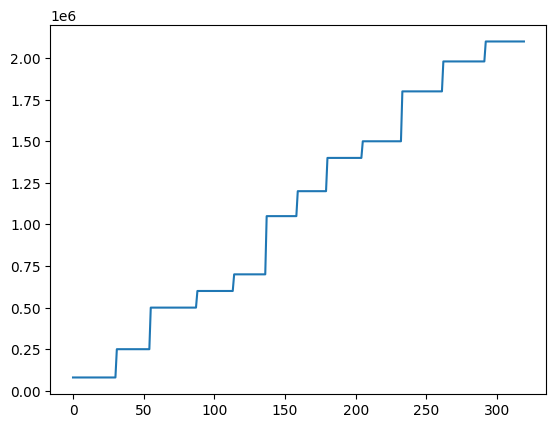

In [5]:
batch_size = 40
pivot = [80000, 250000, 500000, 600000, 700000, 1050000, 1200000, 1400000, 1500000, 1800000, 1980000, 2100000]
batches = []


for i in range(len(pivot)):
  batch_size = batch_size + random.randint(-10, 10)
  for j in range(batch_size):
    
    batches.append(pivot[i]+j)
plt.plot(batches)
plt.show()



## Training

In [ ]:
[S, feat] = df.shape
#current_state = 500002
#s = current_state
#current_episode = 0
#total_episodes = 1000000

bounds = [(min_f, max_f), (0,1)]

alpha = 0.01
gamma = 1

my_batches = batches


for nn in NN_new:

    print("NN: ", names_new[NN_new.index(nn)])
    try:
        nn.load_weights('/content/gdrive/MyDrive/Tesi_GDrive/weights_new/net_' + NN_new.index(nn) + '.h5')
        print("try")
    except:
        print("except")
        pass

    w0 = nn.get_weights()
    convergence = False

    while convergence == False:
    
        #for current_episode in range(total_episodes):
        for i in range(len(my_batches)):

            s = my_batches[i]
            s_prime = s+1
            if s_prime > S-1:
                print("s =", s)
                break
            # a1 = frequenza sul motore di mandata
            #a1 = df.loc[s,'F_M_FDBK_00']
            a1 = a_f_m_scaled[s][0]
            

            # a2 = percentuale di apertura delle valvole caldo/freddo (esclusive)
            a_raf = df.loc[s,'VLV_RAF_REG_00']
            a_sur = df.loc[s,'VLV_SUR_REG_00']
            if a_raf == 0:
                if a_sur == 0:
                    a2 = 0
                else:
                    a2 = a_sur_df[s]
            else:
                a2 = a_raf_df[s]

            # r = reward 
            r = -df.loc[s,'PW_ATT_M_00']
           
            x0 = np.array([a1, a2])
            # Minimizzazione della -NN per predizione di q' per ottenere a' (a1', a2')
            print("minimizing...")
            #x0 = a.reshape(2,)
            print("x0: ", x0)
            start_time = time.time()
            objective_minimized = differential_evolution(objective, bounds=bounds, args=(s_prime,nn,n_components,), x0=x0, maxiter=300, tol=0.01, polish=True)
            end_time = time.time()
            print("time elapsed: ", end_time - start_time, "seconds")
            
            # Compongo input della predizione di q'
            a1_prime_input = np.array([objective_minimized.x[0]]).reshape(1,1)
            a2_prime_input = objective_minimized.x[1].reshape(1,1)
            s_prime_input = pca_df.loc[s_prime,:].values.reshape(n_components,1)
            conc1 = np.concatenate((s_prime_input, a1_prime_input), axis=0)
            a2_prime_input = np.expand_dims(a2_prime_input, axis=1).reshape(1,1)
            conc2 = np.concatenate((conc1, a2_prime_input), axis=0)
            nn_input_prime = np.reshape(conc2, (1,input_dim))
            # Compongo input della predizione di q
            a1_input = np.array([a1]).reshape(1,1)
            a2_input = np.array([a2]).reshape(1,1)
            s_input = pca_df.loc[s,:].values.reshape(n_components,1)
            conc1 = np.concatenate((s_input, a1_input), axis=0)
            a2_input = np.expand_dims(a2_input, axis=1).reshape(1,1)
            conc2 = np.concatenate((conc1, a2_input), axis=0)
            nn_input = np.reshape(conc2, (1,input_dim))

            # Predizione di q'
            q_prime = nn.predict(nn_input_prime, verbose = 0)[0]
            q_prime = q_prime[0]

            # Predizione di q
            q_ = nn.predict(nn_input, verbose = 0)[0] 
            q_ = q_[0]

            # q = avr + gamma*max(q')
            q = q_ + alpha*(r + gamma*q_prime - q_)
            
            # Calcola il valore target per il training della rete neurale
            target = q
            target = np.array([target])

            # Aggiornamento della rete neurale
            nn.fit(nn_input, target, epochs=1, verbose=0)
            w1 = nn.get_weights()

            # Aggiornamento  dello stato corrente
            #s = s_prime

            # Plot statistiche ogni n episodi    
            n_print = 5
            if s%n_print == 0:
                print("\n")
                print("current_episode = ", s)
                #print("Episodio ",s,"/",total_episodes)
                print("q: ", q)
                print("F_M_FDBK_00: ", df.loc[s,'F_M_FDBK_00'])
                print("VLV_RAF_REG_00: ", df.loc[s,'VLV_RAF_REG_00'])
                print("VLV_SUR_REG_00: ", df.loc[s,'VLV_SUR_REG_00'])
                print("PW_ATT_M_00: ", df.loc[s,'PW_ATT_M_00'])
                print("\n")
                if IN_COLAB == True:
                  nn.save_weights('/content/gdrive/MyDrive/Tesi_GDrive/weights_new/'+names_new[NN_new.index(nn)]+'.h5')
                else:
                  string = ['/weights/DQN_',names[NN.index(nn)],'_tansig_'+str(n_components)+'input.h5']
                  string = ''.join(string)
                  nn.save_weights(string)

            # Convergenza
            if are_weights_equal(w0, w1) == True:
                #print("####### w0 \n", w0)
                #print("####### w1 \n", w1)
                convergence = True
                print("Convergenza raggiunta\n")
                if IN_COLAB == True:
                  nn.save_weights('/content/gdrive/MyDrive/Tesi_GDrive/weights/DEF'+names_new[NN_new.index(nn)]+'.h5')
                else:  
                  string = ['/weights/DEF_DQN_',names[NN.index(nn)],'_tansig_'+str(n_components)+'input.h5']
                  string = ''.join(string)
                  nn.save_weights(string)
                break

NN:  net_1
except
minimizing...
x0:  [0.9965497 0.       ]
time elapsed:  31.95055913925171 seconds


current_episode =  80000
q:  -0.2456896024942398
F_M_FDBK_00:  99.993
VLV_RAF_REG_00:  0.0
VLV_SUR_REG_00:  0.0
PW_ATT_M_00:  0.0


minimizing...
x0:  [0.99645602 0.        ]
time elapsed:  50.43307971954346 seconds
minimizing...
x0:  [0.99650187 0.        ]
time elapsed:  33.64064073562622 seconds
minimizing...
x0:  [0.99636832 0.        ]
time elapsed:  45.677443981170654 seconds
minimizing...
x0:  [0.99633244 0.        ]
time elapsed:  35.94814944267273 seconds
minimizing...
x0:  [0.99635038 0.        ]
time elapsed:  37.57414531707764 seconds


current_episode =  80005
q:  -0.19256412208080292
F_M_FDBK_00:  99.973
VLV_RAF_REG_00:  0.0
VLV_SUR_REG_00:  0.0
PW_ATT_M_00:  0.0


minimizing...
x0:  [0.99624673 0.        ]
time elapsed:  42.37400937080383 seconds
minimizing...
x0:  [0.99591585 0.        ]
time elapsed:  32.05157828330994 seconds
minimizing...
x0:  [0.99605339 0.        ]

## Policy Extraction

In [ ]:
NN_trained = NN_new

[S, feat] = df.shape

bounds = [(min_f, max_f), (0,1)]

alpha = 0.01
gamma = 1

my_batches = batches

names_trained = names

df_optim_list = []

my_batches = batches

for nn in NN_trained:

    try:
        nn.load_weights('/content/gdrive/MyDrive/Tesi_GDrive/weights_new/DEF'+names_trained[NN_trained.index(nn)]+'.h5')
    except:
        nn.load_weights('/content/gdrive/MyDrive/Tesi_GDrive/weights_new/'+names_trained[NN_trained.index(nn)]+'.h5')

    print("NN: ", names_trained[NN_trained.index(nn)])

    rows = []
    
    for i in range(len(my_batches)):

        s = my_batches[i]
        s_prime = s+1

        if s_prime > S-1:
            print("s =", s)
            break

        a1 = a_f_m_scaled[s][0]

        a_raf = df.loc[s, 'VLV_RAF_REG_00']
        a_sur = df.loc[s, 'VLV_SUR_REG_00']

        if a_raf == 0:
          if a_sur == 0:
            a2 = 0
          else:
            a2 = a_sur_df[s]
        else:
          a1 = a_raf_df[s]

        x0 = np.array([a1,a2])

        start_time = time.time()

        objective_minimized = differential_evolution(objective, bounds=bounds, args=(s_prime,nn,n_components,), x0=x0, maxiter=300, tol=0.01, polish=True)
        
        end_time = time.time()
        print("time elapsed: ", end_time - start_time, "seconds")

        a1 = np.array([objective_minimized.x[0]]).reshape(1,1)
        a2 = np.array([objective_minimized.x[1]]).reshape(1,1)
        pca_s = pca_df.loc[s,:]
        nn_input = np.concatenate((pca_s.values.reshape(n_components,1), a1, a2), axis=0)
        nn_input = np.reshape(nn_input, (1,input_dim))
        q_star = nn.predict(nn_input, verbose = 0)[0][0]

        a1_star = objective_minimized.x[0]
        a2_star = objective_minimized.x[1]

        rows.append({'s' : s, 'a1*' : a1_star, 'a2*' : a2_star, 'q*' : q_star})

        n_print = 5
        if s%n_print == 0:
          print("\n")
          print("s: ", s)
          print("q*: ", q_star)
          print("a1*: ", a1_star, "F_M_FDBK_00: ", df.loc[s,'F_M_FDBK_00'])
          print("a2*: ", a2_star)
          print("\n")

    df_optim = pd.DataFrame(rows)

    # Specifica il nome della directory cluster_model
    nn_model = names_trained[NN_trained.index(nn)]

    # Crea il percorso completo per la directory cluster_model
    nn_model_directory = os.path.join(PROJECT_PATH, 'df_policy_new', nn_model)

    # Crea la directory cluster_model se non esiste
    if not os.path.exists(nn_model_directory):
        os.makedirs(nn_model_directory)
        print("Directory", nn_model, "creata con successo!")

    # Salvataggio del df* nella directory df_policy
    nn_file_path = os.path.join(nn_model_directory, 'nn_' + nn_model + '.csv')
    np.save(nn_file_path, df_optim)

    df_optim_list.append(df_optim)





        
